In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

print(xx.shape)
print(yy.shape)

(40000, 4)
(40000, 88)


In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5])
lb=np.array([0.01,0.3,-0.95,0.025])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =32,shuffle=True)

device is cuda


In [4]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':4,'hidden_dim':64,'hidden_nums':10,'output_dim':88,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 6.542218655483636
test loss is 6.321132222693506
Batch: 100,train loss is: 0.9137970289471534
test loss is 0.9803507092049465
Batch: 200,train loss is: 0.5796298653142559
test loss is 0.5616630363900925
Batch: 300,train loss is: 0.3189059762563323
test loss is 0.29785782282142037
Batch: 400,train loss is: 0.18879063456416903
test loss is 0.16068631511458586
Batch: 500,train loss is: 0.09150847073184672
test loss is 0.09653201926773106
Batch: 600,train loss is: 0.05672624566881238
test loss is 0.06201800940415917
Batch: 700,train loss is: 0.04808788058381935
test loss is 0.04440505316334852
Batch: 800,train loss is: 0.034253416946270064
test loss is 0.033766286925211164
Batch: 900,train loss is: 0.026950287731599586
test loss is 0.027497276544425034
Batch: 1000,train loss is: 0.020756571093228378
test loss is 0.023903384282941847
-----------------------Epoch: 1----------------------------------
Bat

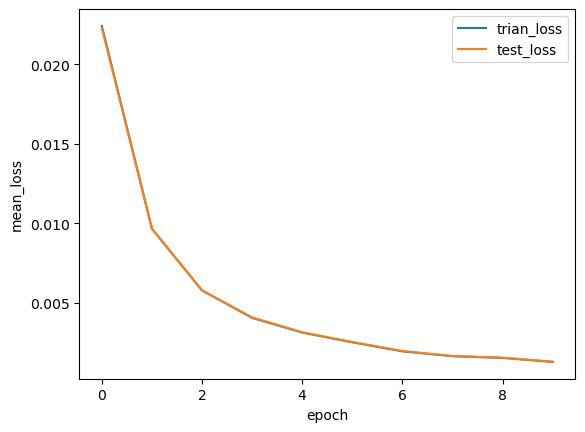

In [5]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.0015931489369324868
test loss is 0.0012544321817668704
Batch: 100,train loss is: 0.0009293166403688282
test loss is 0.0011825931947841012
Batch: 200,train loss is: 0.0009494347112596605
test loss is 0.0011315063513202296
Batch: 300,train loss is: 0.0013392010362522772
test loss is 0.0011655077835872516
Batch: 400,train loss is: 0.00104335094726273
test loss is 0.001135856464276383
Batch: 500,train loss is: 0.0015373111678045675
test loss is 0.0011319223101310223
Batch: 600,train loss is: 0.0009874935800063206
test loss is 0.0011331450157050337
Batch: 700,train loss is: 0.000920791082685329
test loss is 0.0011275164966208133
Batch: 800,train loss is: 0.0011705781209393473
test loss is 0.0011444164116115561
Batch: 900,train loss is: 0.001031593698800788
test loss is 0.0011144269548627665
Batch: 1000,train loss is: 0.0010501784276066265
test loss is 0.0011092938026619403
-----------------------Epoc

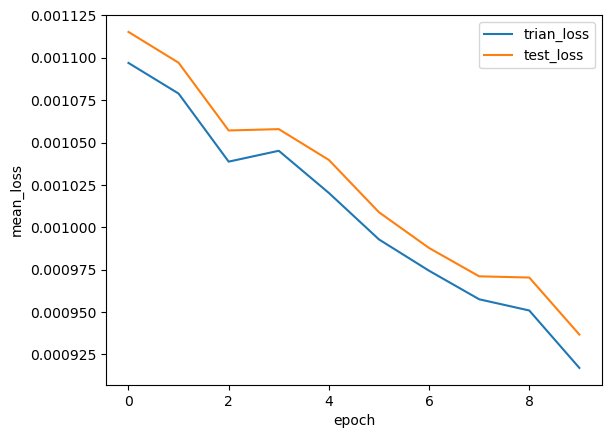

In [6]:
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.00001)

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

In [7]:
torch.save(model.state_dict(),'../../Data/YU/rflatBergomi.pth')